In [36]:
import folium

from collections import Counter

from math import sqrt, floor
import numpy as np
from imageio import imread

%matplotlib notebook
from matplotlib import pyplot as plt

from skimage.morphology import binary_closing
from skimage.measure import find_contours, label

import folium.plugins
from folium_jsbutton import JsButton

In [18]:
im = imread('../data/dialects.png')

color_occurence = Counter(map(tuple, im.reshape(-1,3)))
colors_sorted_by_occurence = [c for c, _ in sorted(
    color_occurence.items(),
    key=lambda x: x[1],
    reverse=True)
]

<IPython.core.display.Javascript object>


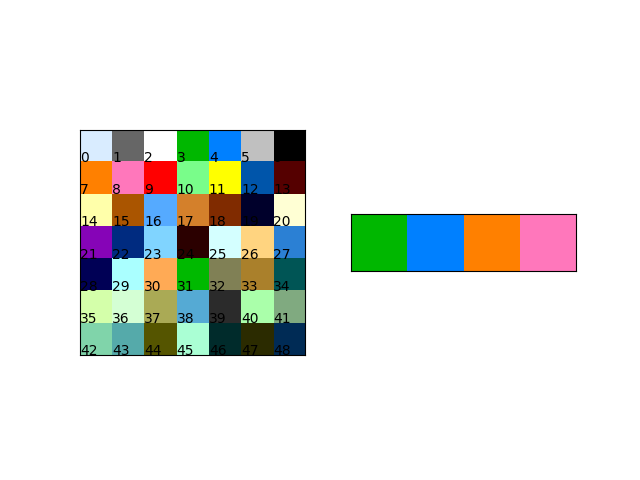

In [31]:
pallette_width = floor(sqrt(len(colors_sorted_by_occurence)))
pallette = np.array(colors_sorted_by_occurence[:pallette_width**2]).reshape(pallette_width, pallette_width, 3)

_, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(pallette)
for x in range(pallette_width):
    for y in range(pallette_width):
        ax0.text(x-0.5, y+0.5, str(x + y * pallette_width))
ax0.set_xticks([]), ax0.set_yticks([])



pallette_indices = [3, 4, 7, 8]
pallette = [colors_sorted_by_occurence[i] for i in pallette_indices]
pallette = np.array(pallette).reshape(1, -1, 3)
ax1.imshow(pallette)
ax1.set_xticks([]), ax1.set_yticks([])
None

In [37]:
bounds = [
    [52.832432288794514, 5.354483127593994],
    [53.41434089638827, 6.330699920654297]
]

m = folium.Map(
    location=[(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2],
    tiles='stamentoner',
    zoom_start=9
)

folium.raster_layers.ImageOverlay()

m

AttributeError: module 'folium.plugins' has no attribute 'ImageOverlay'

In [ ]:
print(geojson)

In [ ]:
plt.rcParams['figure.figsize'] = (9.5, 3)
ax0, ax1, ax2 = plt.subplots(1,3)[1]
ax0.imshow(im)
ax1.imshow(composed_49.astype(int))
ax2.imshow(composed_4.astype(int))
ax0.set_xticks([]); ax0.set_yticks([])
ax1.set_xticks([]); ax1.set_yticks([])
ax2.set_xticks([]); ax2.set_yticks([])
plt.tight_layout()



stavoren_to_east_pixels = [295, 717]
north_to_south_pixels = [99, 525]

In [ ]:
axes = plt.subplots(2,2)[1].ravel()
contours = []
for axis, c in zip(axes, relevant_colors):
    bi = (im[:-100] == c[None,None]).min(axis=2)
    bi = binary_closing(bi, np.ones((5,5)))
    
    labels = label(bi, background=False)
    
    contours.append(find_contours(bi, 0.5))

    axis.imshow(bi)
    for n, contour in enumerate(contours[-1][:1]):
        axis.plot(contour[:, 1], contour[:, 0], linewidth=2)
        axis.set_xticks([]); axis.set_yticks([])
plt.tight_layout()

In [3]:
a0, b0 = stavoren_to_east_coords
c0, d0 = stavoren_to_east_pixels

scale_x = lambda x: (x - c0) / (d0 - c0) * (b0 - a0) + a0

a1, b1 = north_to_south_coords
c1, d1 = north_to_south_pixels

scale_y = lambda x: (x - c1) / (d1 - c1) * (b1 - a1) + a1

contours_scaled = [
    list(zip(scale_x(c[0][:, 1]), scale_y(c[0][:, 0])))
    for c in contours
]

NameError: name 'stavoren_to_east_coords' is not defined

In [4]:
geojson = json.dumps({
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {'dialect': dialect},
      "geometry": {
        "type": "Polygon",
        "coordinates": [list(map(list, contour))]
      }
    }
    for contour, dialect in zip(contours_scaled, regions)
  ]
})

with open('dialect_regions.geojson', 'w') as f:
    f.write(geojson)

NameError: name 'contours_scaled' is not defined

NameError: name 'north_to_south_coords' is not defined

In [6]:
shapes = {
    dialect: shape({"type": "Polygon", "coordinates": [list(map(list, contour))]})
    for contour, dialect in zip(contours_scaled, regions)
}

def regions_for(coordinate):
    regions = {
        region_name
        for region_name, shape in shapes.items()
        if shape.contains(Point(*coordinate))
    }
    return regions

def distance(shape, longitude, latitude):
    ext = shape.exterior
    p = ext.interpolate(ext.project(Point(longitude, latitude)))
    return vincenty((latitude, longitude), (p.y, p.x))

NameError: name 'contours_scaled' is not defined

In [7]:
# SELECT user_lat, user_lng, question_text, answer_text
picture_games = pandas.read_sql('''
SELECT language.name as language, item.name as picture,
       survey.user_lat as latitude, survey.user_lng as longitude,
       survey.area_name as area, survey.country_name as country,
       result.recording as filename,
       result.submitted_at as date
FROM       core_surveyresult as survey
INNER JOIN core_picturegameresult as result ON survey.id = result.survey_result_id
INNER JOIN core_language as language ON language.id = result.language_id
INNER JOIN core_picturegameitem as item
    ON result.picture_game_item_id = item.id
''', db)
# picture_games['filename'] = [filename.split('/')[-1] for filename in picture_games['filename']]
picture_games.set_index('filename', inplace=True)

In [8]:
region_per_picture_game = [
    {
        'dialects': [
            {
                'dialect': dialect,
                'boundary_distance': distance(shapes[dialect], longitude, latitude),
            }
            for dialect in regions_for((longitude, latitude))
        ],
        'filename': filename,
    }
    for filename, (latitude, longitude) in ProgressBar(
        picture_games[['latitude', 'longitude']].iterrows(),
        size=len(picture_games)
    )
]

NameError: name 'regions_for' is not defined

In [ ]:
Counter(len(x['dialects']) for x in region_per_picture_game)

In [ ]:
df = pandas.DataFrame([
    [r['filename'], r['dialects'][0]['dialect'], r['dialects'][0]['boundary_distance']]
    for r in region_per_picture_game
    if len(r['dialects']) == 1
], columns = ['filename', 'dialect', 'boundary_distance'])

df.to_excel('picture_game_recordings_by_dialect.xlsx')
df.to_csv('picture_game_recordings_by_dialect.csv')
df

In [9]:
# SELECT user_lat, user_lng, question_text, answer_text
free_speech_games = pandas.read_sql('''
SELECT language.name as language,
       survey.user_lat as latitude, survey.user_lng as longitude,
       survey.area_name as area, survey.country_name as country,
       result.recording as filename,
       result.submitted_at as date
FROM       core_surveyresult as survey
INNER JOIN core_freespeechresult as result ON survey.id = result.survey_result_id
INNER JOIN core_language as language ON language.id = result.language_id
''', db)
# free_speech_games['filename'] = [filename.split('/')[-1] for filename in games['filename']]
free_speech_games.set_index('filename', inplace=True)